In [117]:
from numpy import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift
from  matplotlib.animation import FuncAnimation

%matplotlib widget

# Map creation ----------------------------------------------------------------
class SeaMap:
    def __init__(self, shape, frequency, volume_mean, volume_sd, nest):
        self.shape = shape
        self.frequency = frequency 
        self.volume_mean = volume_mean
        self.volume_sd = volume_sd
        self.nest = nest

        self.map = np.zeros(shape)

        self.map_history = []

    def __save_map(self):
        self.map_history.append(np.array(self.map))

    # Generate resource point (point = uniform() : volume = normal())
    def __gen_resource_point(self, x, y):
        if random.uniform(0, 1) < self.frequency and (x != self.nest[0] and y != self.nest[1]):
            volume = max(0, random.normal(loc=self.volume_mean, scale=self.volume_sd))
            self.map[x][y] = volume
        else:
            self.map[x][y] = 0

    # Consume volume in that point, return amount consumed
    def consume_point(self, x, y, val):
        consumed = 0
        if self.map[x][y] - val >= 0:
            consumed = val
            self.map[x][y] = self.map[x][y] - val
        else:
            consumed = self.map[x][y]
            self.map[x][y] = 0

        self.__save_map()
        return consumed

    # Fill initial points
    def gen_map(self):        
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                self.__gen_resource_point(i, j)

        self.__save_map()

    # Shift map
    def shift_map(self, shiftx, shifty):
        self.map = shift(self.map, (shiftx, shifty), cval=np.nan)

        nans = np.argwhere(np.isnan(self.map))

        for coord in nans:
            self.__gen_resource_point(coord[0], coord[1])
        
        self.__save_map()

    def show_map(self):
        fig, ax = plt.subplots()
        # Using matshow here just because it sets the ticks up nicely. imshow is faster.
        ax.matshow(self.map, cmap="seismic")

        for (i, j), z in np.ndenumerate(self.map):
            if z > 1e-10:
                ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

        plt.show()

    def animate_map(self):
        fig = plt.figure()
        plot = plt.imshow(self.map_history[0])

        def update(i):
            plot.set_data(self.map_history[i])
            return [plot]

        anim = FuncAnimation(fig, update, interval=100, blit=True)
        return anim
        # plt.show()



In [118]:
# Event -----------------------------------------------
import heapq as hq

class Event:
    ARRIVAL = 0
    DEPARTURE = 1
    MAP = 2

    def __init__(self, id, type, time, shift=0, coord=(-1,-1)):
        self.id = id
        self.type = type
        self.time = time
        self.shift = shift
        self.coord = coord

    def __lt__(self, other):
        return (self.time < other.time)

event_list = []

    

In [119]:
class Stats:
    def __init__(self):
        self.consumptions = []
        self.distances = [] 

class Sim:
    # Time in hours
    # Volume in kg

    DAY = 24
    ARRIVAL_RATE = 1/2.4216 # From out input modelling

    def __init__(self, nest_location, grid_shape, resource_frequency, 
                 volume_mean, volume_sd, total_days):
        # Parameters for map
        self.nest_location = nest_location
        self.grid_shape = grid_shape
        self.resource_frequency = resource_frequency
        self.volume_mean = volume_mean
        self.volume_sd = volume_sd
        self.total_days = total_days

        self.seamap = SeaMap(
            shape = self.grid_shape, 
            frequency = self.resource_frequency,
            volume_mean = self.volume_mean,
            volume_sd = self.volume_sd,
            nest = self.nest_location
        )

        self.clock = 0
        self.event_list = []
        self.event_count = 0

        self.stats = Stats()

    def initialize_sim(self):
        # Generate map
        self.seamap.gen_map()

        # Create first arrival
        arrival_event = Event(self.event_count, Event.ARRIVAL, self.clock + random.exponential(self.ARRIVAL_RATE))
        self.event_count += 1
        hq.heappush(self.event_list, arrival_event)

        # Create first map event
        map_event = Event(self.event_count, Event.MAP, self.clock + self.DAY, 2)
        self.event_count += 1
        hq.heappush(self.event_list, map_event)
    
    def __square_distance(self, point1, point2):
        return(
            np.power(point1[0]-point2[0], 2) +
            np.power(point1[1]-point2[1], 2)
        )

    def process_map_shift(self, event):
        self.seamap.shift_map(event.shift, 0)

        # Create another map event
        map_event = Event(self.event_count, Event.MAP, self.clock + self.DAY, 2)
        self.event_count += 1
        hq.heappush(self.event_list, map_event)

    def process_arrival(self, event):
        # Get all resource locations
        coords = np.transpose(np.nonzero(self.seamap.map))

        # No resource points
        if len(coords) <= 0:
            # Do stats
            self.stats.consumptions.append(0) 
            self.stats.distances.append(-1)

            # Create another arrival
            arrival_event = Event(self.event_count, Event.ARRIVAL, self.clock + random.exponential(self.ARRIVAL_RATE))
            self.event_count += 1
            hq.heappush(self.event_list, arrival_event)

            return

        # Calc distance and get volumes
        distances = np.zeros(coords.shape[0])
        volumes = np.zeros(coords.shape[0])
        for i in range(coords.shape[0]):
            distances[i] = self.__square_distance(self.nest_location, coords[i])
            volumes[i] = self.seamap.map[coords[i][0]][coords[i][1]]

        # Normalize and combine to create rating
        if coords.shape[0] != 1:
            distances = 1 - ((distances-np.min(distances))/(np.max(distances)-np.min(distances))) 
            volumes = (volumes-np.min(volumes))/(np.max(volumes)-np.min(volumes)) 
        else:
            distances = np.array([1]) 
            volumes = np.array([1])

        ratings = (distances + volumes) / 2
        sort_ind = np.argsort(ratings)[::-1]

        # Get all high ratings based on an epsilon
        epsilon = 0.1
        cur_rating = ratings[sort_ind[0]]
        high_rated = [sort_ind[0]]
        i = 0 

        while(cur_rating >= ratings[sort_ind[0]] - epsilon and i < len(ratings) - 1):
            high_rated.append(sort_ind[i])
            i += 1
            cur_rating = ratings[sort_ind[i]]

        # Pick at random
        choice = high_rated[random.choice(len(high_rated), 1)[0]]

        # Consume
        consumption = random.normal(0.17, 0.04) # Distribution from https://www.nature.com/articles/s41598-021-02451-4#Sec9
        true_consumption = self.seamap.consume_point(coords[choice][0], coords[choice][1], consumption)

        # Do stats
        self.stats.consumptions.append(true_consumption) 
        self.stats.distances.append(np.sqrt(self.__square_distance(self.nest_location, coords[choice])))

        # Create another arrival
        arrival_event = Event(self.event_count, Event.ARRIVAL, self.clock + random.exponential(self.ARRIVAL_RATE))
        self.event_count += 1
        hq.heappush(self.event_list, arrival_event)

    def run(self):
        self.initialize_sim()

        # Main loop
        while len(self.event_list) > 0 and self.clock < self.DAY * self.total_days:
            cur_event = hq.heappop(self.event_list)
            self.clock = cur_event.time

            if cur_event.type == Event.ARRIVAL:
                self.process_arrival(cur_event)
            else:
                self.process_map_shift(cur_event)
        
        self.stats.consumptions = np.array(self.stats.consumptions)
        self.stats.distances = np.array(self.stats.distances)

0.16979041155536392
5.217739357306227
278


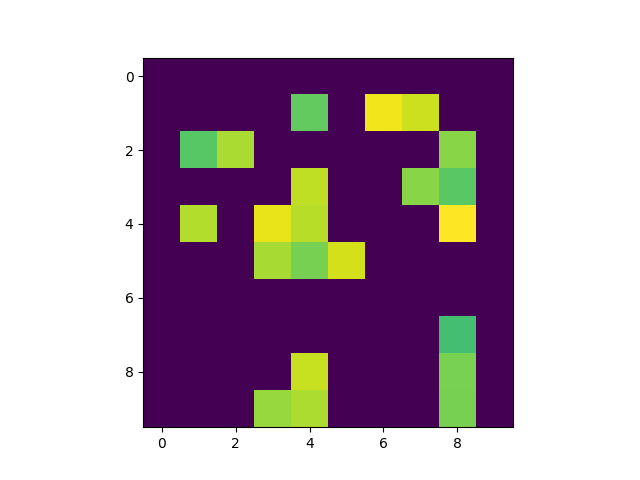

In [120]:
random.seed(1)

sim = Sim(
    nest_location=(0,0),
    grid_shape=(10,10),
    resource_frequency=0.2,
    volume_mean=10,
    volume_sd=1,
    total_days=5,
)

sim.run()

print(np.mean(sim.stats.consumptions))
print(np.mean(sim.stats.distances))
print(len(sim.seamap.map_history))

fig = plt.figure()
plot = plt.imshow(sim.seamap.map_history[0])

def update(i):
    plot.set_data(sim.seamap.map_history[i])
    return [plot]

anim = FuncAnimation(fig, update, interval=100, blit=True)
plt.show()